# Do not overfit -- Kaggle

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score

In [2]:
data_path = 'data/'
train_data = pd.read_csv(f'{data_path}train.csv', index_col = 'id')
test_data = pd.read_csv(f'{data_path}test.csv', index_col = 'id')

In [3]:
corrs = train_data.drop(labels = ['target'], axis = 1).corr().abs().unstack().sort_values(kind="quicksort").reset_index()
corrs = corrs[corrs['level_0'] != corrs['level_1']]
corrs.tail(10)

,level_0,level_1,0
89690,79,187,0.243916
89691,187,79,0.243916
89692,140,187,0.244012
89693,187,140,0.244012
89694,28,22,0.246062
89695,22,28,0.246062
89696,193,101,0.252825
89697,101,193,0.252825
89698,32,75,0.259315
89699,75,32,0.259315


In [4]:
train_data['target'].value_counts()

1.0    160
0.0     90
Name: target, dtype: int64

In [5]:
columns_impact = pd.DataFrame(
    columns = ['column_name', 'mean_impact_on_0', 'mean_impact_on_1', 'std_0', 'std_1']
)
for col in train_data.columns[train_data.columns != 'target']:
    columns_impact = columns_impact.append(dict(
        column_name = col
        , mean_impact_on_0 = train_data[train_data['target'] == 0][col].mean()
        , mean_impact_on_1 = train_data[train_data['target'] == 1][col].mean()
        , std_0 = train_data[train_data['target'] == 0][col].std()
        , std_1 = train_data[train_data['target'] == 1][col].std()
    )
                                          , ignore_index = True)

In [6]:
columns_impact['upper_l_0'] = columns_impact['mean_impact_on_0'] + 1.96 * columns_impact['std_0']
columns_impact['upper_l_1'] = columns_impact['mean_impact_on_1'] + 1.96 * columns_impact['std_1']
columns_impact['lower_l_0'] = columns_impact['mean_impact_on_0'] - 1.96 * columns_impact['std_0']
columns_impact['lower_l_1'] = columns_impact['mean_impact_on_1'] - 1.96 * columns_impact['std_1']
columns_impact['overlap'] = columns_impact.apply(
lambda row: min(row['upper_l_0'], row['upper_l_1']) - max(row['lower_l_0'], row['lower_l_1'])
    , axis = 1
)
columns_impact['spread'] = columns_impact.apply(
lambda row: max(row['upper_l_0'], row['upper_l_1']) - min(row['lower_l_0'], row['lower_l_1'])
    , axis = 1
)
columns_impact['opportunity'] = (columns_impact['spread'] - columns_impact['overlap'])/columns_impact['spread']
columns_impact['oppor_factor'] = columns_impact.apply(
lambda row: 0 if (((row['upper_l_0'] > row['upper_l_1']) and (row['lower_l_0'] < row['lower_l_1']))
    or ((row['upper_l_0'] < row['upper_l_1']) and (row['lower_l_0'] > row['lower_l_1']))) else 1
    , axis = 1
)
columns_impact['opportunity'] = columns_impact['opportunity'] * columns_impact['oppor_factor']

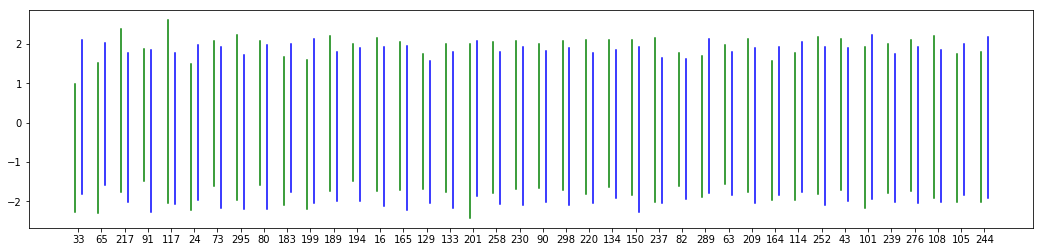

In [7]:
columns_impact = columns_impact.sort_values(by=['opportunity'], ascending = [False])

plt.figure(figsize=(18,4))
for num, col in enumerate(columns_impact['column_name'][:40]):
    plt.plot([num-0.15, num-0.15], [columns_impact[columns_impact['column_name'] == col].loc[int(col), 'upper_l_0']
                                    , columns_impact[columns_impact['column_name'] == col].loc[int(col), 'lower_l_0']], 'g')
    plt.plot([num+0.15, num+0.15], [columns_impact[columns_impact['column_name'] == col].loc[int(col), 'upper_l_1']
                                    , columns_impact[columns_impact['column_name'] == col].loc[int(col), 'lower_l_1']], 'b')
plt.xticks(np.arange(num + 1), list(columns_impact['column_name']))
plt.show()
columns_impact_1 = columns_impact.reset_index(drop=True)

In [8]:
my_folds = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 10, random_state = 2)
C = np.linspace(start = 0.0001, stop = 1, num=51)
hyperparameters = dict(C = C)
cols_seq = list(range(2, 100))
tuned_score = []
for total_cols in cols_seq:
    best_columns = list(
    columns_impact['column_name'][:total_cols]
    )
    train_subset = train_data[best_columns + ['target']]
    cl_log = LogisticRegression(penalty = 'l2', max_iter = 100)
    grid_log = GridSearchCV(cl_log
                            , hyperparameters
                            , cv = my_folds
                            , verbose = 0
                            , scoring = 'roc_auc')
    grid_log.fit(train_subset[train_subset.columns[train_subset.columns != 'target']], train_subset['target'])
    tuned_score.append(grid_log.best_score_)

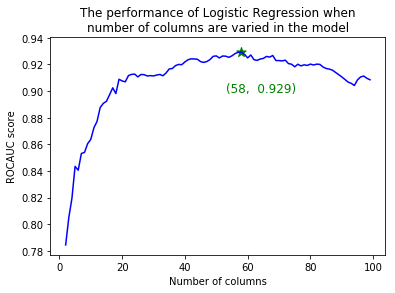

In [28]:
s = '({0:2d}, {1:6.3f})'.format(cols_seq[tuned_score.index(max(tuned_score))], max(tuned_score))

plt.plot(cols_seq, tuned_score, 'b')
plt.title('The performance of Logistic Regression when\nnumber of columns are varied in the model')
plt.xlabel('Number of columns')
plt.ylabel('ROCAUC score')
plt.scatter(cols_seq[tuned_score.index(max(tuned_score))], max(tuned_score), marker='*', s = 100, c = 'g')
plt.text(
    cols_seq[tuned_score.index(max(tuned_score))] - 5
    , max(tuned_score) - 0.03
    , s
    , fontsize=12
    , color = 'green'
)
plt.show()

In [29]:
best_columns = list(
    columns_impact['column_name'][:58]
    )
train_data = train_data[best_columns + ['target']]

train_X, val_X, train_y, val_y = train_test_split(
    train_data[train_data.columns[train_data.columns != 'target']]
    , train_data['target']
    , random_state = 1
    , test_size = 0.2
)

cl_log = LogisticRegression()
cl_log.fit(train_X, train_y)

yhat = cl_log.predict_proba(val_X)[:, 1]

# calculate aucroc
aucroc = roc_auc_score(val_y, yhat)

print('aucroc=%.3f' % aucroc)

aucroc=0.915


In [30]:
cl_log_final = LogisticRegression()
cl_log_final.fit(train_data[train_data.columns[train_data.columns != 'target']], train_data['target'])
test_yhat = cl_log_final.predict_proba(test_data[train_data.columns[train_data.columns != 'target']])[:, 1]
submission_df = pd.DataFrame({'target' : test_yhat}, index = test_data.index)

In [31]:
submission_df.to_csv(f'{data_path}logreg_basic.csv', sep = ',')

In [32]:
my_folds = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 10, random_state = 2)

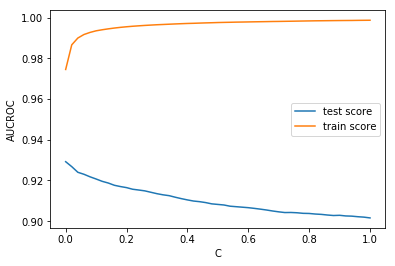

In [33]:
C = np.linspace(start = 0.0001, stop = 1, num=51)
hyperparameters = dict(C = C)
cl_log = LogisticRegression(penalty = 'l2', max_iter = 100)
grid_logl2 = GridSearchCV(cl_log
                        , hyperparameters
                        , cv = my_folds
                        , verbose = 0
                        , scoring = 'roc_auc'
                        , return_train_score = True)
grid_logl2.fit(train_data[train_data.columns[train_data.columns != 'target']], train_data['target'])

test_scores = grid_logl2.cv_results_['mean_test_score']
train_scores = grid_logl2.cv_results_['mean_train_score']
param_C = grid_logl2.cv_results_['param_C']
plt.plot(param_C, test_scores, label = 'test score')
plt.plot(param_C, train_scores, label = 'train score')
plt.xlabel('C')
plt.ylabel('AUCROC')
plt.legend()
plt.show()

In [34]:
print('The best value of C:  ' +
      "{:.5f}".format(grid_logl2.best_params_['C']) +
      '\nThe best AUCROC score:  ' +
      "{:.3f}".format(grid_logl2.best_score_)
     )

The best value of C:  0.00010
The best AUCROC score:  0.929


In [35]:
cl_log_final = LogisticRegression(
    penalty = 'l2'
    , max_iter = 100
    , C = 0.0001
)
cl_log_final.fit(train_data[train_data.columns[train_data.columns != 'target']], train_data['target'])
test_yhat = cl_log_final.predict_proba(test_data[train_data.columns[train_data.columns != 'target']])[:, 1]
submission_df = pd.DataFrame({'target' : test_yhat}, index = test_data.index)
submission_df.to_csv(f'{data_path}logreg_tunedl2.csv', sep = ',')

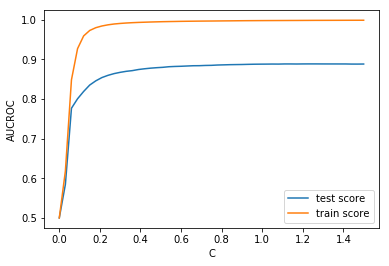

In [36]:
C = np.linspace(start = 0.0001, stop = 1.5, num=51)
hyperparameters = dict(C = C)
cl_log = LogisticRegression(penalty = 'l1', max_iter = 100)
grid_logl1 = GridSearchCV(cl_log
                        , hyperparameters
                        , cv = my_folds
                        , verbose = 0
                        , scoring = 'roc_auc'
                        , return_train_score = True)
grid_logl1.fit(train_data[train_data.columns[train_data.columns != 'target']], train_data['target'])

test_scores = grid_logl1.cv_results_['mean_test_score']
train_scores = grid_logl1.cv_results_['mean_train_score']
param_C = grid_logl1.cv_results_['param_C']
plt.plot(param_C, test_scores, label = 'test score')
plt.plot(param_C, train_scores, label = 'train score')
plt.xlabel('C')
plt.ylabel('AUCROC')
plt.legend()
plt.show()

In [37]:
print('The best value of C:  ' +
      "{:.5f}".format(grid_logl1.best_params_['C']) +
      '\nThe best AUCROC score:  ' +
      "{:.3f}".format(grid_logl1.best_score_)
     )

The best value of C:  1.23002
The best AUCROC score:  0.889


In [38]:
cl_log_final = LogisticRegression(
    penalty = 'l1'
    , max_iter = 100
    , C = 1.23
)
cl_log_final.fit(train_data[train_data.columns[train_data.columns != 'target']], train_data['target'])
test_yhat = cl_log_final.predict_proba(test_data[train_data.columns[train_data.columns != 'target']])[:, 1]
submission_df = pd.DataFrame({'target' : test_yhat}, index = test_data.index)
submission_df.to_csv(f'{data_path}logreg_tunedl1.csv', sep = ',')

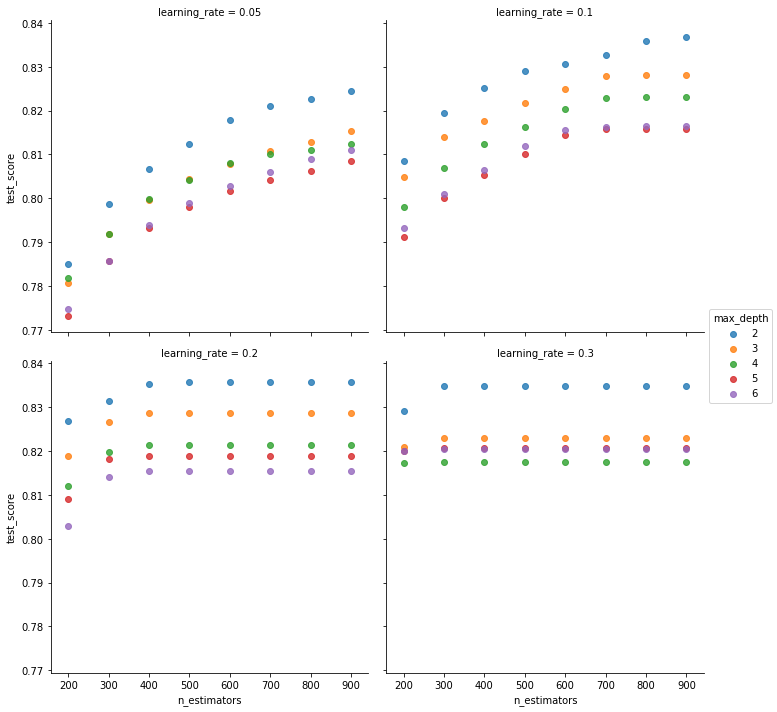

In [53]:
xgb_clf = XGBClassifier(objective = 'binary:logistic'
                        , booster = 'gbtree'
                        , n_jobs = -1)
xgb_grid1 = {"n_estimators" : range(200, 1000, 100)
             , "learning_rate" : [0.05, 0.1, 0.2, 0.3]
             , "max_depth" : [2, 3, 4, 5, 6]
             , "gamma" : [0]
             , "colsample_bytree" : [1]
             , "min_child_weight" : [1]
             , "subsample" : [1]
            }

xgb_gridsearch1 = GridSearchCV(estimator = xgb_clf
                               , param_grid = xgb_grid1
                               , verbose = 0
                               , cv = my_folds
                               , scoring = 'roc_auc')
xgb_gridsearch1.fit(train_data[train_data.columns[train_data.columns != 'target']], train_data['target'])

xgb_gridsearch1_results = pd.DataFrame(xgb_gridsearch1.cv_results_['params'])
xgb_gridsearch1_results['test_score'] = xgb_gridsearch1.cv_results_['mean_test_score']

sb.lmplot(x = 'n_estimators'
          , y = 'test_score'
          , data = xgb_gridsearch1_results
          , hue = 'max_depth'
          , col = 'learning_rate'
          , fit_reg = False
          , col_wrap = 2
         )

plt.show()

In [54]:
xgb_gridsearch1.best_params_

{'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_depth': 2,
 'min_child_weight': 1,
 'n_estimators': 900,
 'subsample': 1}

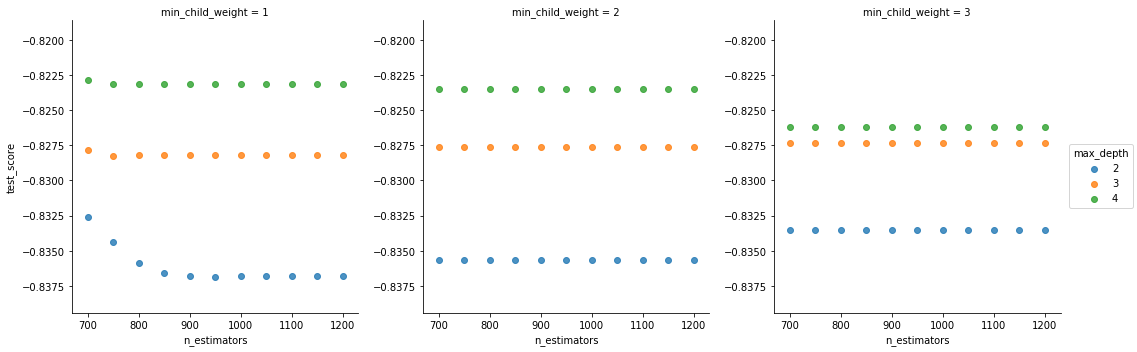

In [55]:
xgb_grid2 = {"n_estimators" : range(700, 1250, 50)
             , "learning_rate" : [0.1]
             , "max_depth" : [2, 3, 4]
             , "gamma" : [0]
             , "colsample_bytree" : [1]
             , "min_child_weight" : [1, 2, 3]
             , "subsample" : [1]
            }

xgb_gridsearch2 = GridSearchCV(estimator = xgb_clf
                               , param_grid = xgb_grid2
                               , verbose = 0
                               , scoring = 'roc_auc'
                               , cv = my_folds)
xgb_gridsearch2.fit(train_data[train_data.columns[train_data.columns != 'target']], train_data['target'])

xgb_gridsearch2_results = pd.DataFrame(xgb_gridsearch2.cv_results_['params'])
xgb_gridsearch2_results['test_score'] = xgb_gridsearch2.cv_results_['mean_test_score']

sb.lmplot(x = 'n_estimators'
          , y = 'test_score'
          , data = xgb_gridsearch2_results
          , hue = 'max_depth'
          , col = 'min_child_weight'
          , fit_reg = False
         )

plt.show()

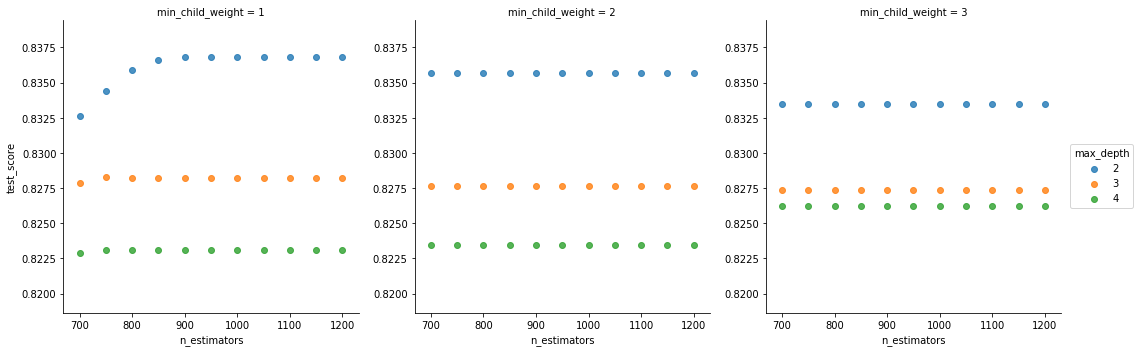

In [56]:
xgb_gridsearch2_results = pd.DataFrame(xgb_gridsearch2.cv_results_['params'])
xgb_gridsearch2_results['test_score'] = xgb_gridsearch2.cv_results_['mean_test_score']

sb.lmplot(x = 'n_estimators'
          , y = 'test_score'
          , data = xgb_gridsearch2_results
          , hue = 'max_depth'
          , col = 'min_child_weight'
          , fit_reg = False
         )

plt.show()

In [57]:
xgb_gridsearch1.best_params_

{'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_depth': 2,
 'min_child_weight': 1,
 'n_estimators': 900,
 'subsample': 1}

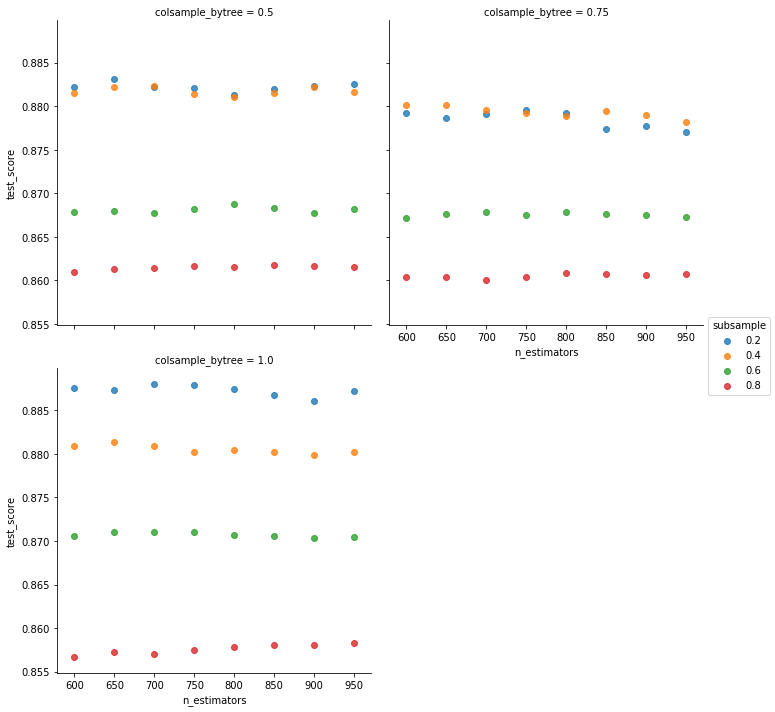

In [63]:
xgb_grid3 = {"n_estimators" : range(600, 1000, 50)
             , "learning_rate" : [0.1]
             , "max_depth" : [2]
             , "gamma" : [0]
             , "colsample_bytree" : [.5, .75, 1]
             , "min_child_weight" : [1]
             , "subsample" : [0.2, 0.4, 0.6, 0.8]
            }

xgb_gridsearch3 = GridSearchCV(estimator = xgb_clf
                               , param_grid = xgb_grid3
                               , verbose = 0
                               , scoring = 'roc_auc'
                               , cv = my_folds)
xgb_gridsearch3.fit(train_data[train_data.columns[train_data.columns != 'target']], train_data['target'])

xgb_gridsearch3_results = pd.DataFrame(xgb_gridsearch3.cv_results_['params'])
xgb_gridsearch3_results['test_score'] = xgb_gridsearch3.cv_results_['mean_test_score']

sb.lmplot(x = 'n_estimators'
          , y = 'test_score'
          , data = xgb_gridsearch3_results
          , hue = 'subsample'
          , col = 'colsample_bytree'
          , fit_reg = False
          , col_wrap = 2
         )

plt.show()

In [64]:
xgb_gridsearch3.best_params_

{'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_depth': 2,
 'min_child_weight': 1,
 'n_estimators': 700,
 'subsample': 0.2}

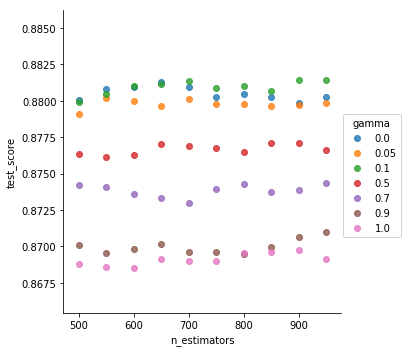

In [66]:
xgb_grid4 = {"n_estimators" : range(500, 1000, 50)
             , "learning_rate" : [0.1]
             , "max_depth" : [2]
             , "gamma" : [0, 0.05, 0.1, 0.5, 0.7, 0.9, 1.0]
             , "colsample_bytree" : [1]
             , "min_child_weight" : [1]
             , "subsample" : [0.4]
            }

xgb_gridsearch4 = GridSearchCV(estimator = xgb_clf
                               , param_grid = xgb_grid4
                               , verbose = 0
                               , scoring = 'roc_auc'
                               , cv = my_folds)
xgb_gridsearch4.fit(train_data[train_data.columns[train_data.columns != 'target']], train_data['target'])

xgb_gridsearch4_results = pd.DataFrame(xgb_gridsearch4.cv_results_['params'])
xgb_gridsearch4_results['test_score'] = xgb_gridsearch4.cv_results_['mean_test_score']

sb.lmplot(x = 'n_estimators'
          , y = 'test_score'
          , data = xgb_gridsearch4_results
          , hue = 'gamma'
          , fit_reg = False
         )

plt.show()

In [67]:
xgb_gridsearch4.best_params_

{'colsample_bytree': 1,
 'gamma': 0.1,
 'learning_rate': 0.1,
 'max_depth': 2,
 'min_child_weight': 1,
 'n_estimators': 900,
 'subsample': 0.4}

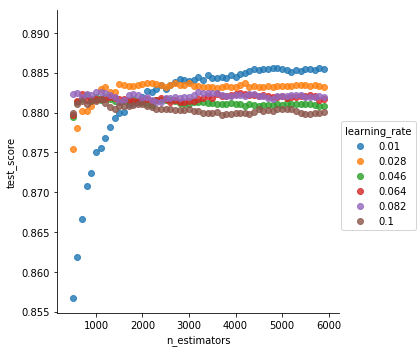

In [69]:
xgb_grid5 = {"n_estimators" : range(500, 6000, 100)
             , "learning_rate" : [0.010, 0.028, 0.046, 0.064, 0.082, 0.100]
             , "max_depth" : [2]
             , "gamma" : [0.1]
             , "colsample_bytree" : [1]
             , "min_child_weight" : [1]
             , "subsample" : [0.4]
            }

xgb_gridsearch5 = GridSearchCV(estimator = xgb_clf
                               , param_grid = xgb_grid5
                               , verbose = 0
                               , scoring = 'roc_auc'
                               , cv = my_folds
                               , return_train_score = True)
xgb_gridsearch5.fit(train_data[train_data.columns[train_data.columns != 'target']], train_data['target'])

xgb_gridsearch5_results = pd.DataFrame(xgb_gridsearch5.cv_results_['params'])
xgb_gridsearch5_results['test_score'] = xgb_gridsearch5.cv_results_['mean_test_score']
xgb_gridsearch5_results['train_score'] = xgb_gridsearch5.cv_results_['mean_train_score']

sb.lmplot(x = 'n_estimators'
          , y = 'test_score'
          , data = xgb_gridsearch5_results
          , hue = 'learning_rate'
          , fit_reg = False
         )

plt.show()

In [70]:
xgb_gridsearch5.best_params_

{'colsample_bytree': 1,
 'gamma': 0.1,
 'learning_rate': 0.01,
 'max_depth': 2,
 'min_child_weight': 1,
 'n_estimators': 5800,
 'subsample': 0.4}

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


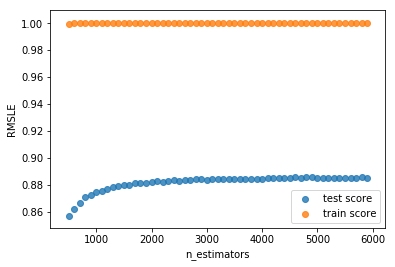

In [72]:
sb.regplot(x = 'n_estimators', y='test_score'
           , data = xgb_gridsearch5_results[xgb_gridsearch5_results['learning_rate'] == 0.01]
           , fit_reg = False
           , label = 'test score')
sb.regplot(x = 'n_estimators', y='train_score'
           , data = xgb_gridsearch5_results[xgb_gridsearch5_results['learning_rate'] == 0.01]
           , fit_reg = False
           , label = 'train score')
plt.ylabel('RMSLE')
plt.legend()
plt.show()

In [74]:
final_xgb = XGBClassifier(objective = 'binary:logistic'
                          , booster = 'gbtree'
                          , n_jobs = -1
                          , n_estimators = 5800
                          , learning_rate = 0.01
                          , max_depth = 2
                          , gamma = 0.1
                          , colsample_bytree = 1
                          , min_child_weight = 1
                          , subsample = 0.4
                         )
final_xgb.fit(train_data[train_data.columns[train_data.columns != 'target']], train_data['target'])
test_yhat = final_xgb.predict_proba(test_data[train_data.columns[train_data.columns != 'target']])[:, 1]
submission_df = pd.DataFrame({'target' : test_yhat}, index = test_data.index)
submission_df.to_csv(f'{data_path}xgb_tuned.csv', sep = ',')

In [75]:
final_xgb = XGBClassifier(objective = 'binary:logistic'
                          , booster = 'gblinear'
                          , n_jobs = -1
                          , n_estimators = 5800
                          , learning_rate = 0.01
                          , max_depth = 2
                          , gamma = 0.1
                          , colsample_bytree = 1
                          , min_child_weight = 1
                          , subsample = 0.4
                         )
final_xgb.fit(train_data[train_data.columns[train_data.columns != 'target']], train_data['target'])

XGBClassifier(base_score=0.5, booster='gblinear', colsample_bylevel=1,
       colsample_bytree=1, gamma=0.1, learning_rate=0.01, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=5800,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.4)

In [89]:
sum(train_data[train_data.columns[train_data.columns != 'target']].mean().abs() > .05)


23